In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('zinc_prices_IMF.csv')

In [17]:
data.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
Date     434 non-null object
Price    434 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.9+ KB


In [19]:
data.describe()

,Price
count,434.000000
mean,1362.338594
std,677.071321
min,597.450000
25%,875.355000
50%,1088.875000
75%,1742.052500
max,4381.450000


In [20]:
data.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [21]:
data.loc[:,'Date']= pd.to_datetime(data['Date'])

In [22]:
data.set_index('Date', inplace=True)

In [23]:
data.head()

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07


In [24]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Date', length=434, freq=None)

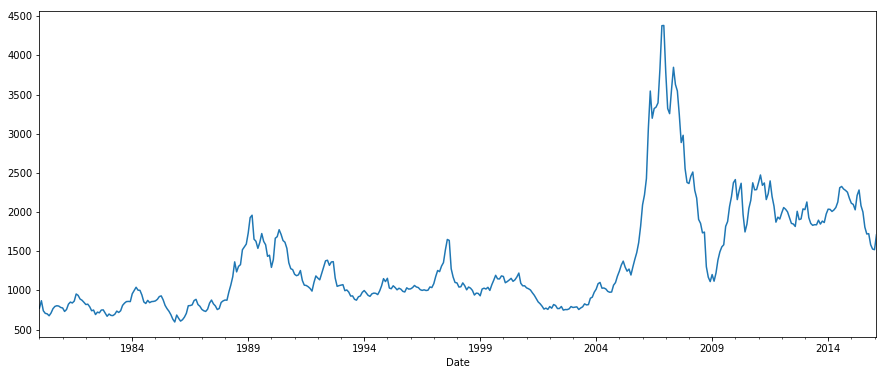

In [25]:
ts = data['Price']
ts.plot()

In [26]:
ts_log = np.log(ts)

In [27]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

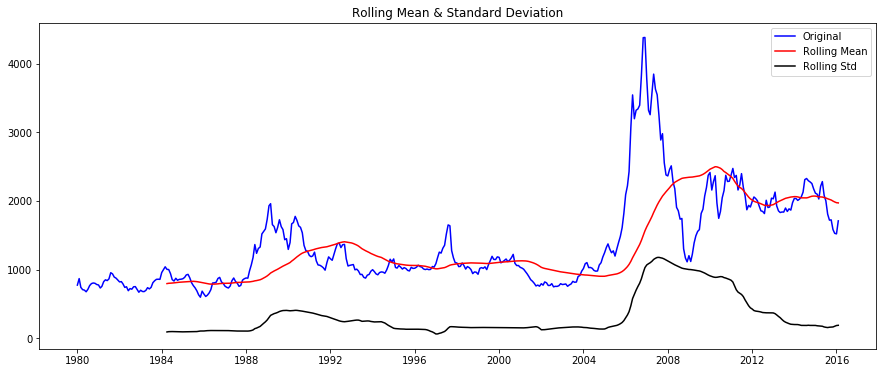

Results of Dickey-Fuller Test:
Test Statistic                  -3.139601
p-value                          0.023758
#Lags Used                       7.000000
Number of Observations Used    426.000000
Critical Value (1%)             -3.445794
Critical Value (5%)             -2.868349
Critical Value (10%)            -2.570397
dtype: float64


In [28]:
test_stationarity(data['Price'])

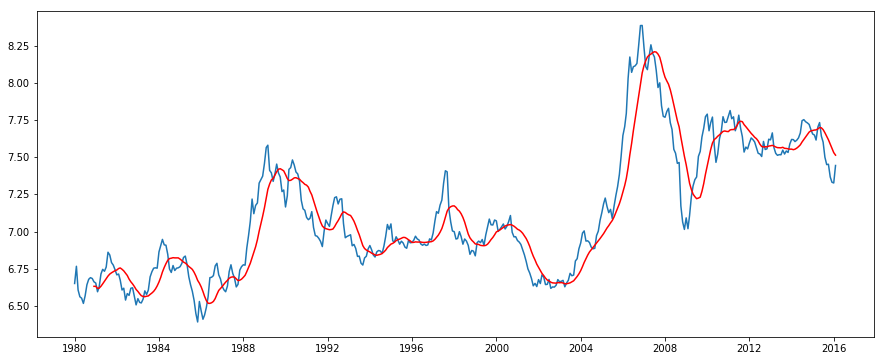

In [29]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [30]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Date
1980-12-01    0.030472
1981-01-01    0.021753
1981-02-01   -0.022485
1981-03-01    0.008392
1981-04-01    0.082191
1981-05-01    0.097617
1981-06-01    0.066587
1981-07-01    0.078914
1981-08-01    0.160180
1981-09-01    0.127928
Name: Price, dtype: float64

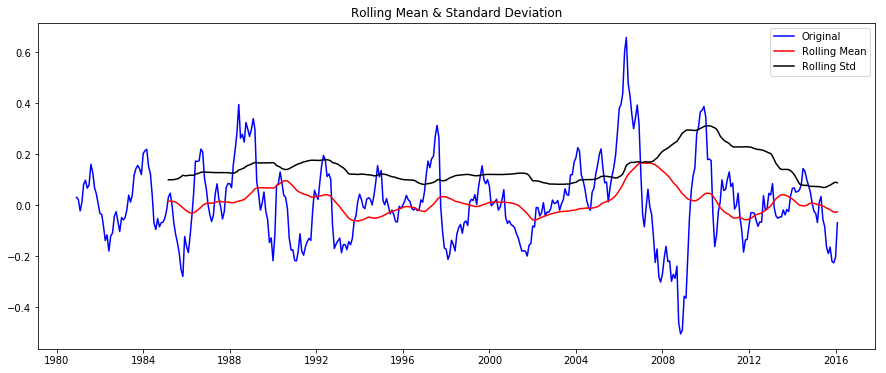

Results of Dickey-Fuller Test:
Test Statistic                -5.898484e+00
p-value                        2.814411e-07
#Lags Used                     4.000000e+00
Number of Observations Used    4.180000e+02
Critical Value (1%)           -3.446091e+00
Critical Value (5%)           -2.868479e+00
Critical Value (10%)          -2.570466e+00
dtype: float64


In [31]:
test_stationarity(ts_log_mv_diff)

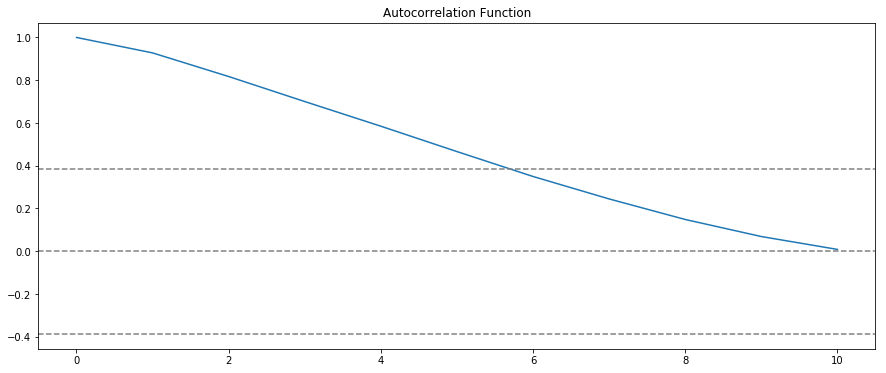

In [32]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

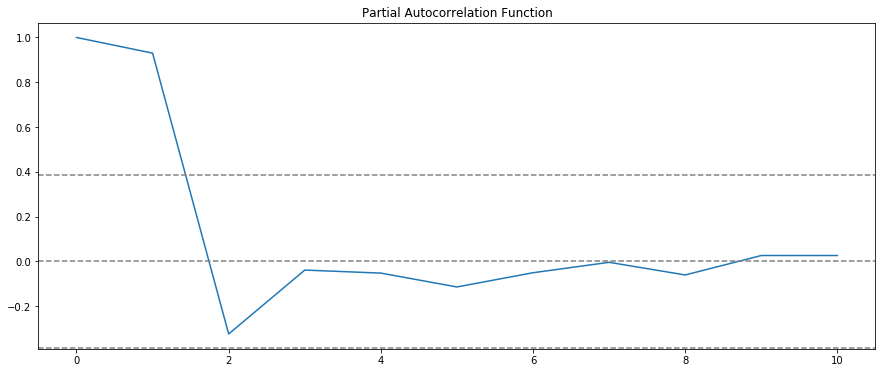

In [33]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

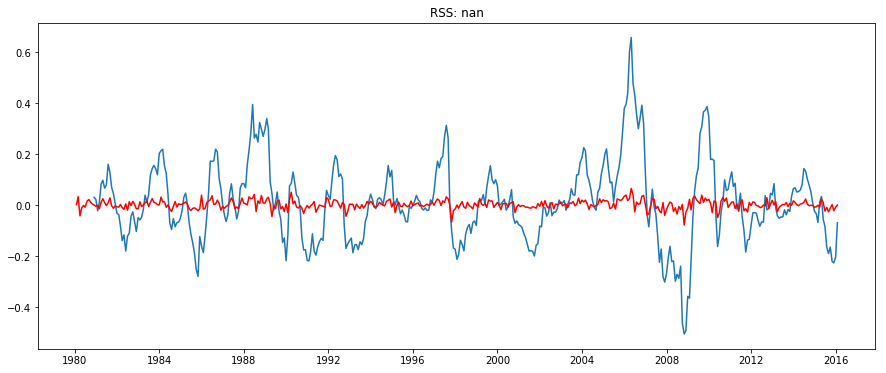

In [34]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [35]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1980-02-01    0.002030
1980-03-01    0.033049
1980-04-01   -0.042031
1980-05-01   -0.011002
1980-06-01   -0.001089
dtype: float64

In [36]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1980-02-01    0.002030
1980-03-01    0.035079
1980-04-01   -0.006952
1980-05-01   -0.017955
1980-06-01   -0.019043
dtype: float64

In [37]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1980-01-01    6.651339
1980-02-01    6.653369
1980-03-01    6.686418
1980-04-01    6.644387
1980-05-01    6.633384
dtype: float64

Text(0.5, 1.0, 'RMSE: 429.0141')

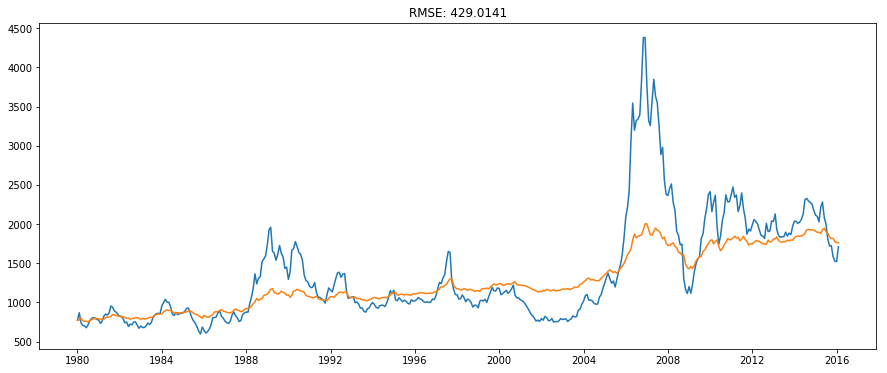

In [38]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
